# Tripadvisor Data Analysis

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn import linear_model
import scipy.stats as stats
from matplotlib.colors import ListedColormap
import warnings
warnings.simplefilter(action='ignore')

## Reading Data

In [2]:
data=pd.read_csv(r'C:\Users\berka\PycharmProjects\upwork\deliveroo\trip_advisor\tripadvisor files\tripadvisor complete file.csv', low_memory=False)
pd.options.display.float_format = '{:,.3f}'.format

In [3]:
df = data.copy()
df = df[['country code', 'city', 'name of restaurant', 'rating', '# of reviews','tag 1', 'tag 2', 'tag 3']]
df['name of restaurant']=df['name of restaurant'].fillna('-')

## Defining Franchisors

In [4]:
# extracting franchisors list
groupby_count=df.groupby(by='name of restaurant')['city'].count().sort_values(ascending=False)
franchisor_index=groupby_count[groupby_count>10].index

# assigning Franchisor column
df=df.assign(franchise=np.where(df['name of restaurant'].isin(franchisor_index), 'Franchisor', 'Local'))

# filtering the restaurants in the franchisors list
fran_rests=df.loc[df['name of restaurant'].isin(franchisor_index)]

# grouping new franchisors df with country code and name of rests
groupby_fr=fran_rests.groupby(by=['name of restaurant','country code'])['city'].describe().sort_values(axis=0,by=['country code','count'],ascending=False)
groupby_fr.reset_index(inplace=True)
groupby_fr.head()
big_rests=df.loc[df['name of restaurant'].isin(franchisor_index)]

# 1) Restaurant count analysis

## Franchisor Percentages across the countries

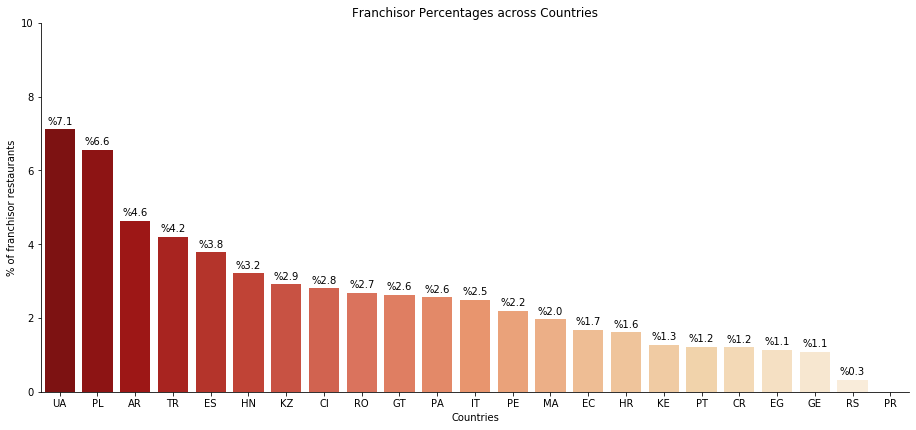

In [5]:
# adding percentage column
count_by_fran=df.groupby(by=['country code','franchise'], as_index=False)
count_by_fran_df=pd.DataFrame(count_by_fran['city'].describe()['count'])
count_by_fran_df=count_by_fran_df.assign(franc_perc=lambda x: (100/(count_by_fran_df['Franchisor'] + count_by_fran_df['Local'])*count_by_fran_df['Franchisor'])).sort_values(by='franc_perc', ascending=False)
count_by_fran_df.reset_index(inplace=True)

# drawing percentage graph
c=sns.catplot(x='country code',y='franc_perc', data=count_by_fran_df, kind='bar',palette='OrRd_r')
plt.rcParams['font.size']=10
c.set(ylim=(0, 10))
for i in c.ax.patches:
    y_width=i.get_width()/2
    y_val=i.get_height()
    y_val_formatted='%'+("%3.1f" % y_val)
    x=i.get_x()
    c.ax.annotate(str(y_val_formatted),(x+y_width, y_val),ha='center',xytext=(0,5),textcoords='offset points')
    
c.fig.set_size_inches(14,6)
plt.ylabel('% of franchisor restaurants')
_=plt.xlabel('Countries')
_=plt.title('Franchisor Percentages across Countries')

## Sorting top 5 restaurants in each country based on count

In [6]:
# filtering top 5 rests in top 5 countries
top_5_country=df.groupby(by='country code').count().sort_values(by='city', ascending=False).head().index
top_5_country_count= df.loc[df['franchise']=='Franchisor'].groupby(by='country code').count()['city'].to_dict()
top_5_rests=pd.DataFrame()
t=big_rests.groupby(by=['country code', 'name of restaurant'], as_index=False).count().sort_values(by=['country code','city'], ascending=False)
t['perc']=t.apply(lambda x: x['city']/(top_5_country_count[x['country code']])*100,axis=1)
for i in top_5_country:
    z=t.loc[t['country code']==i][['country code','name of restaurant','city','perc']].sort_values(by='city',ascending=False).head()
    top_5_rests=pd.concat([top_5_rests, z])


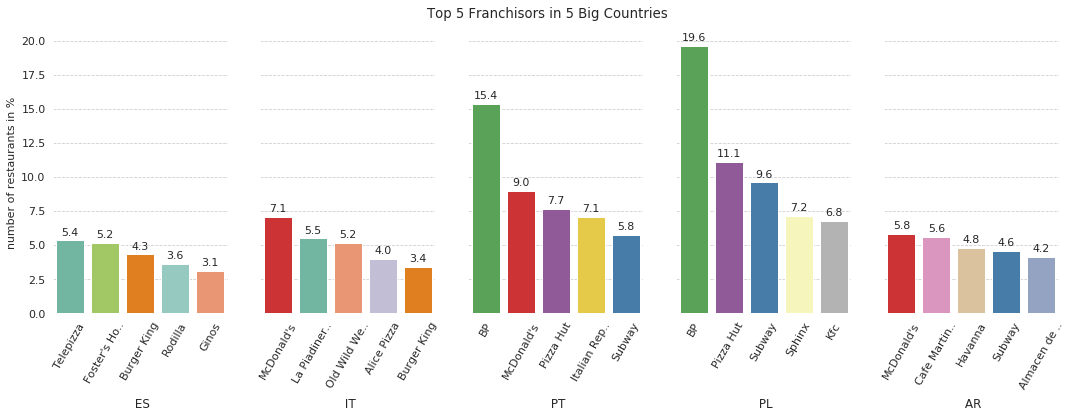

In [7]:
# creating color palette that has unique colors for each restaurant
## sorted list of restaurants to be used in the palette
t_5_gr=top_5_rests.groupby('name of restaurant').count()['city'].sort_values(ascending=False)
current_palette = sns.color_palette("Set1", 5) + sns.color_palette("Set2", 10) + sns.color_palette("Set3", 3)
cmap = ListedColormap(sns.color_palette(current_palette).as_hex())
dct={}
for color,name in zip(cmap.colors, t_5_gr.index):
    m={name:color}
    dct.update(m)
    
# creating barplot 
with sns.axes_style("white",{'axes.grid' : True ,'axes.edgecolor':'w',  'font.family': ['sans-serif']}):
    plt.rcParams['font.size']=11
    plt.Figure(figsize=(14,14))
    g = sns.FacetGrid(col='country code',data=top_5_rests,col_wrap=5, sharex=False, sharey=True, aspect=1, height=1)
    g.map(sns.barplot, 'name of restaurant',"perc", palette=dct)
    ax_1=g.axes[0]
    ax_1.set_ylabel('number of restaurants in %')
    for ax in g.axes:

        ax.set_xlabel(ax.get_title().split('country code =')[1],fontsize=12,labelpad=15)
        tick_labels=ax.get_xticklabels()
        edited_ticks=[]
        for l in tick_labels:
            l=l.get_text()
            if len(l)>11:
                l=l[:11]+'..'
            edited_ticks.append(l)
        ax.set_xticklabels(edited_ticks)
        ax.grid(True,linestyle='--', alpha=0.2, axis='y', color='k')
        ax.set_title('')
        ax.xaxis.set_label_coords(0.5, -0.3)
        for i in ax.patches:
            y_width=i.get_width()/2
            y_val=i.get_height()
            y_val_formatted="%3.1f" % y_val
            x=i.get_x()
            ax.annotate(str(y_val_formatted),(x+y_width, y_val),ha='center',xytext=(0,5),textcoords='offset points')
    g.fig.set_size_inches(15,6)
    g.fig.subplots_adjust(wspace=3)
    g.set_xticklabels(rotation=60)
    g.fig.tight_layout()
    _=g.fig.suptitle('Top 5 Franchisors in 5 Big Countries', y=0.9)

## Food tag distribution across countries

In [8]:
# merging all three tags into one big chunk
y=df.groupby(by=['country code','tag 1'], as_index=False).count()[['country code','tag 1','city']]
u=df.groupby(by=['country code','tag 2'], as_index=False).count()[['country code','tag 2','city']]
o=df.groupby(by=['country code','tag 3'], as_index=False).count()[['country code','tag 3','city']]
y.columns=['country code', 'tag', 'city']
u.columns=['country code', 'tag', 'city']
o.columns=['country code', 'tag', 'city']
df_con=pd.concat([y,u,o])
last=df_con.groupby(by=['country code','tag'], as_index=False).sum()

In [9]:
# filtering top 5 rests in top 5 countries
top_5_food=pd.DataFrame()
t=last
for i in top_5_country:
    z=t.loc[t['country code']==i][['country code','tag','city']].sort_values(by='city',ascending=False).head()
    top_5_food=pd.concat([top_5_food, z])
top_5_food.columns=['country code', 'tag', 'count']

In [10]:
rest_count_dc=df.groupby(by='country code').count()['city'].to_dict()
top_5_food['total']=top_5_food.apply(lambda x: x['count']/(rest_count_dc[x['country code']])*100,axis=1)

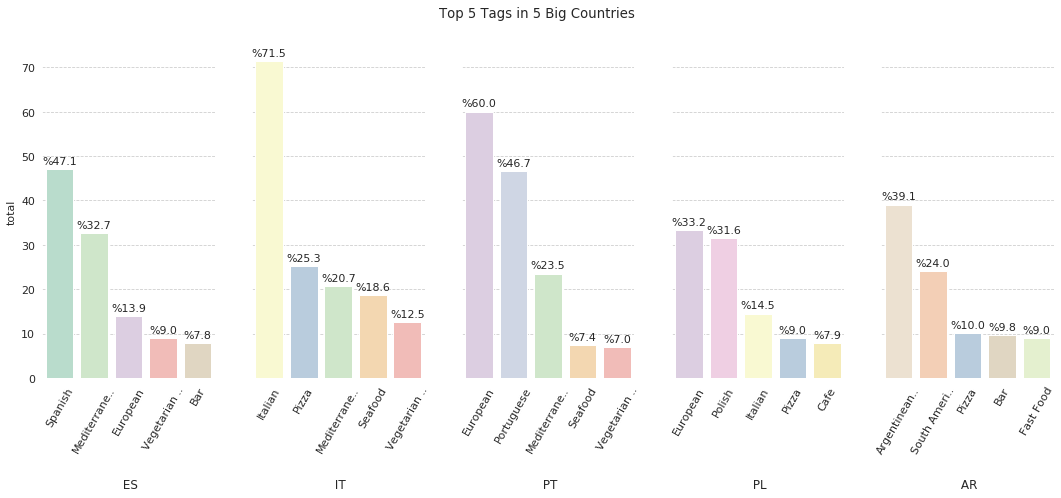

In [11]:
# creating color palette that has unique colors for each restaurant
## sorted list of restaurants to be used in the palette
t_5_gr=top_5_food.groupby('tag').count()['count'].sort_values(ascending=False)
current_palette = sns.color_palette("Pastel1", 7)+sns.color_palette("Pastel2", 7)
cmap = ListedColormap(sns.color_palette(current_palette).as_hex())
dct={}
for color,name in zip(cmap.colors, t_5_gr.index):
    m={name:color}
    dct.update(m)
    
# creating barplot 
with sns.axes_style("white",{'axes.grid' : True ,'axes.edgecolor':'w',  'font.family': ['sans-serif']}):
    plt.rcParams['font.size']=11
    plt.Figure(figsize=(14,14))
    #plt.style.use('seaborn-darkgrid')
    g = sns.FacetGrid(col='country code',data=top_5_food,col_wrap=5, sharex=False, sharey=True, aspect=1, height=1)
    g.map(sns.barplot, 'tag',"total", palette=dct)

    for ax in g.axes:

        ax.set_xlabel(ax.get_title().split('country code =')[1],fontsize=12,labelpad=15)
        tick_labels=ax.get_xticklabels()
        edited_ticks=[]
        for l in tick_labels:
            l=l.get_text()
            if len(l)>10:
                l=l[:11]+'..'
            edited_ticks.append(l)
        ax.set_xticklabels(edited_ticks)
        ax.grid(True,linestyle='--', alpha=0.2, axis='y', color='k')
        ax.set_title('')
        ax.xaxis.set_label_coords(0.5, -0.3)
        for i in ax.patches:
            y_width=i.get_width()/2
            y_val=i.get_height()
            y_val_formatted='%'+("%3.1f" % y_val)
            x=i.get_x()
            ax.annotate(str(y_val_formatted),(x+y_width, y_val),ha='center',xytext=(0,5),textcoords='offset points')
    g.fig.set_size_inches(15,6)
    g.fig.subplots_adjust(wspace=3)
    g.set_xticklabels(rotation=60)
    g.fig.tight_layout()
    _=g.fig.suptitle('Top 5 Tags in 5 Big Countries', y=1.05)

# 2) Score Analysis

## Score distributions

In [12]:
df=df.copy().dropna(subset=['rating','# of reviews'])
df['# of reviews'] = df['# of reviews'].str.replace(',','').astype(np.int32)

In [13]:
count=df['# of reviews']
R=df['rating']
threshold=df['# of reviews'].quantile(0.75)
#threshold=100
Av=(4+3.5)/2
df=df.assign(score=(count/(count+threshold)*R) + 0.5*(threshold/(count+threshold))*Av)
df_cut=df.copy().loc[df['# of reviews']>=threshold]

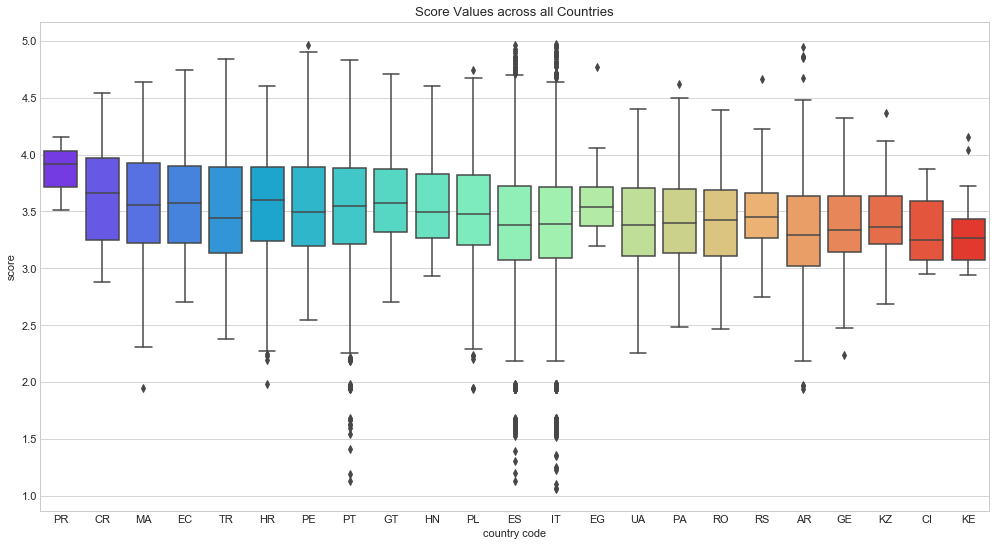

In [14]:
plt.style.use('seaborn-whitegrid')
y='score'
plt.figure(figsize=(17,9))
k=df_cut.groupby(by='country code')[y].quantile(0.75).sort_values(ascending=False).index
sns.boxplot(x='country code', y=y, data=df_cut, palette="rainbow",order=k)
plt.rcParams['font.size']=11
_=plt.title('Score Values across all Countries')

In [15]:
ind=df_cut.groupby(by='country code')['city'].count().sort_values(ascending=False).head().index
ind_city=df_cut.groupby(by='city')['city'].count().sort_values(ascending=False).head(20).index
top_5_country=df_cut.loc[df_cut['country code'].isin(ind)]
top_5_city=df_cut.loc[df_cut['city'].isin(ind_city)]
top_5_city=top_5_city[~top_5_city['city'].str.contains('(NC)',regex=False)]

In [16]:
a=top_5_country[~top_5_country['city'].str.contains('(NC)',regex=False)]
t=a.groupby(by=['country code','city'], as_index=False).count()
t=t.loc[t['country code'].isin(ind)].sort_values(by=['country code','rating'],ascending=False)

In [17]:
sliced=pd.DataFrame([])
for i in ind:
    a=t.loc[t['country code']==i].head(5)
    sliced=pd.concat([sliced, a])
Df=df_cut.loc[df_cut['city'].isin(sliced['city'])].sort_values(by=['country code','city'])
Df['score']=Df['score'].astype(float)

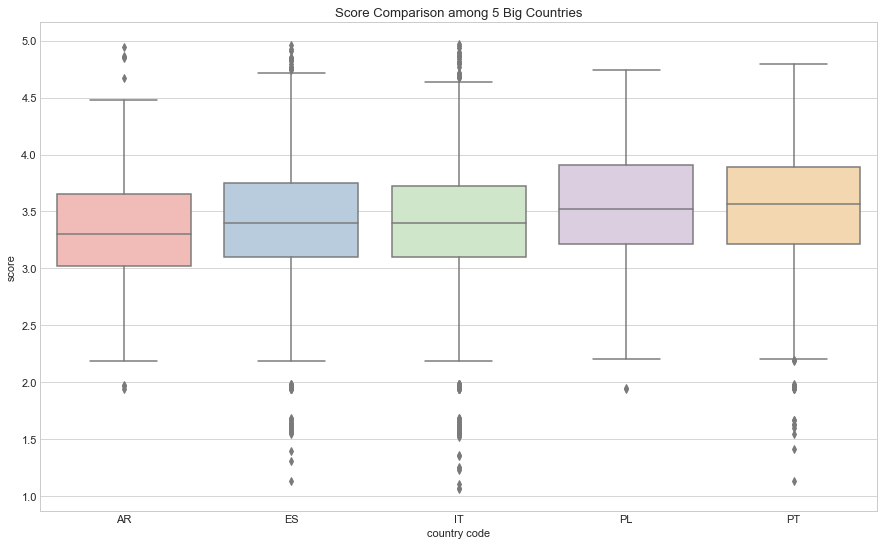

In [18]:
# Score among countries
_=plt.figure(figsize=(15,9))
_=plt.style.use('seaborn-whitegrid')
_=sns.boxplot(x='country code', y='score', data=Df, palette="Pastel1")
_=plt.title('Score Comparison among 5 Big Countries')
_=plt.show()

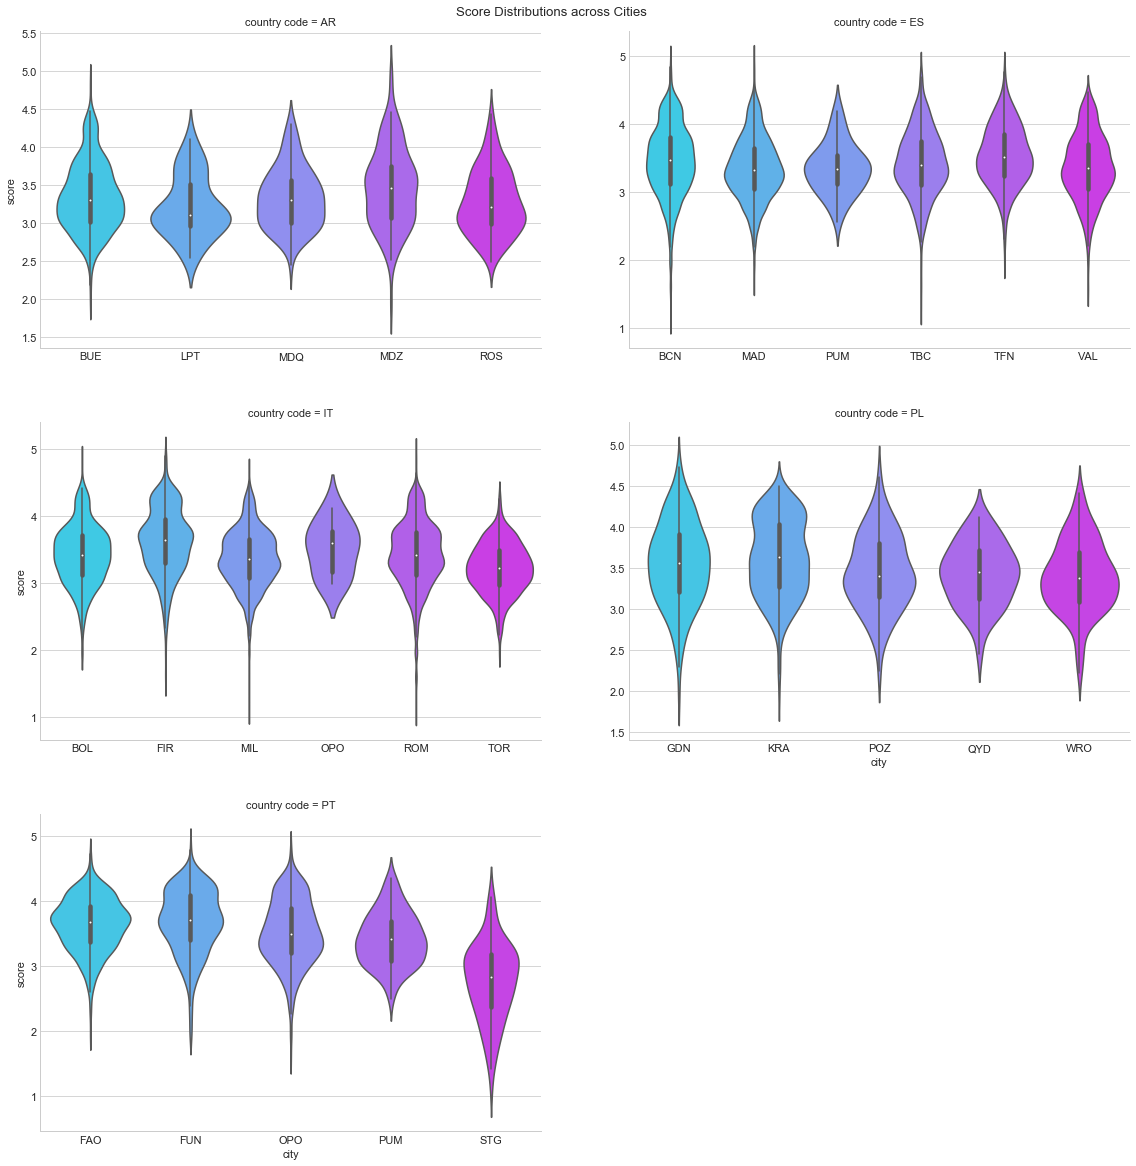

In [19]:
# Score among cities
g = sns.FacetGrid(col='country code',data=Df,col_wrap=2, sharex=False, sharey=False)
plt.rcParams['font.size']=11
_=g.map(sns.violinplot, 'city',"score", palette="cool")
_=g.fig.set_size_inches(17,17)
_=g.fig.suptitle('Score Distributions across Cities')
_=plt.show()

## Ranking Top 100 Restaurants based on Score

In [20]:
# Top 100 Restaurants sorted by 'score'
top_100=df.sort_values(by='score', ascending=False).head(100)
top_100['score']=top_100['score'].astype(float)
top_100=top_100.sort_values(by='score',ascending=False)
top_100.index = np.arange(1, len(top_100) + 1)
top_100

,country code,city,name of restaurant,rating,# of reviews,tag 1,tag 2,tag 3,franchise,score
1,IT,ROM,Nannarella,5.000,10718,Italian,Pizza,Mediterranean,Local,4.968
2,PE,CUZ,Limbus Resto Bar,5.000,9216,Brew Pub,Peruvian,Latin,Local,4.963
3,ES,MAD,Los Montes de Galicia,5.000,8498,International,Mediterranean,Spanish,Local,4.960
4,IT,"(NC) 40.628044,14.364462",Ristorante Bagni Delfino,5.000,7813,Italian,Seafood,Neapolitan,Local,4.956
5,IT,ROM,Pane e Salame,5.000,7665,Italian,Street Food,Romana,Local,4.955
...,...,...,...,...,...,...,...,...,...,...
96,PE,CUZ,PER.UK,5.000,938,Peruvian,International,Fusion,Local,4.669
97,TR,"(NC) 41.004677,28.971193",Arch Bistro,5.000,933,Turkish,Grill,Pub,Local,4.668
98,PT,FAO,Real Portuguese Cuisine,5.000,930,Seafood,Mediterranean,European,Local,4.667
99,RS,QND,Project 72 Wine&Deli,5.000,927,International,European,Fusion,Local,4.666
